In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

# Constant variables
RANDOM_STATE = 42
CV = 5
N_JOBS = -1

# Hilfefunktion für confusion matrix Display, immer heatmap
def plot_confusion_matrix_from_cm(cm, labels=None, title="Confusion Matrix"):
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

# Daten einlesen und vorverarbeiten

In [2]:
with open('data/data_scaled.pickle', 'rb') as f:
    df_scaled = pickle.load(f)
df_scaled.describe()

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_14304\584721221.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df_scaled = pickle.load(f)


,DATE,GOLD_CLOSE,GOLD_VOLUME,SP_CLOSE,SP_VOLUME,DJ_CLOSE,DJ_VOLUME,EG_CLOSE,EG_VOLUME,EU_CLOSE,...,GDX_100,USO_15,USO_100,MONTH,QUARTER,FEAR_GREED,EFFR,GPRD,CPI,LABEL_GOLD
count,1718,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,...,1618.000000,1703.000000,1618.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1707.000000,1718.000000
mean,2015-07-06 19:29:15.995343360,0.366837,0.075239,0.485898,0.170939,0.424765,0.190005,0.329991,0.098171,0.478699,...,-0.080589,-0.040328,-0.087351,0.545693,0.627910,0.505850,0.209196,0.272716,0.329038,-0.035506
min,2011-12-15 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.912176,-1.285804,-1.037401,0.083333,0.250000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,2013-10-03 06:00:00,0.212727,0.042375,0.289154,0.095986,0.247601,0.094059,0.147403,0.054172,0.231463,...,-0.189903,-0.186442,-0.197444,0.333333,0.500000,0.340000,0.029661,0.196216,0.109626,-1.000000
50%,2015-07-18 12:00:00,0.291273,0.064812,0.491892,0.149907,0.388171,0.125866,0.256169,0.081270,0.409783,...,-0.052595,-0.012858,-0.027271,0.583333,0.750000,0.530000,0.050847,0.254719,0.192513,0.000000
75%,2017-04-09 06:00:00,0.382574,0.094324,0.672861,0.223743,0.603162,0.286089,0.446591,0.119259,0.752326,...,0.040048,0.121348,0.084541,0.833333,1.000000,0.680000,0.368644,0.332301,0.508021,1.000000
max,2018-12-31 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.546824,0.867918,0.332710,1.000000,1.000000,0.950000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.239861,0.053311,0.252623,0.102737,0.257898,0.135944,0.263567,0.073775,0.283436,...,0.250000,0.250000,0.250000,0.285445,0.278662,0.224843,0.266818,0.114884,0.294851,0.799983


In [3]:
# Drop columns in scaled data
_symbols = ["GOLD", "SP", "DJ", "EG", "EU", "OF", "OS", "SF", "USB", "PLT", "PLD", "USDI", "GDX", "USO"]
for k in _symbols:
    df_scaled = df_scaled.drop(columns=[k+"_CLOSE"])

df_scaled.dropna(axis=0, inplace=True)
df_scaled = df_scaled.drop(columns=["DATE"])

df_scaled.head(10)

,GOLD_VOLUME,SP_VOLUME,DJ_VOLUME,EG_VOLUME,OF_VOLUME,SF_VOLUME,USDI_VOLUME,GDX_VOLUME,USO_VOLUME,DIFF_GOLD,...,GDX_100,USO_15,USO_100,MONTH,QUARTER,FEAR_GREED,EFFR,GPRD,CPI,LABEL_GOLD
100,0.073497,0.261116,0.156888,0.085625,0.319880,0.354067,0.151513,0.034754,0.031786,3.880005,...,-0.425174,-0.522358,-0.034907,0.416667,0.5,0.25,0.046610,0.157094,0.029412,1
101,0.128779,0.283807,0.151082,0.079784,0.337193,0.291080,0.211964,0.075017,0.038676,5.559997,...,-0.462913,-0.501464,-0.031089,0.416667,0.5,0.23,0.050847,0.169630,0.029412,1
102,0.128414,0.375005,0.165508,0.124152,0.242252,0.352153,0.343724,0.087053,0.047971,6.050003,...,-0.527954,-0.657367,-0.060542,0.416667,0.5,0.20,0.050847,0.246693,0.029412,1
103,0.165208,0.374246,0.151014,0.118161,0.019596,0.528156,0.265270,0.105490,0.087979,5.020004,...,-0.514705,-0.687906,-0.122721,0.416667,0.5,0.14,0.050847,0.172944,0.029412,1
104,0.179617,0.459203,0.155835,0.145665,0.506472,0.487555,0.335668,0.114375,0.043375,3.899994,...,-0.474155,-0.707192,-0.143447,0.416667,0.5,0.12,0.050847,0.134961,0.029412,1
105,0.124510,0.608608,0.260408,0.107066,0.350532,0.443861,0.220580,0.075544,0.056544,0.899994,...,-0.439226,-0.822915,-0.209444,0.416667,0.5,0.12,0.050847,0.403729,0.029412,0
106,0.065446,0.312909,0.149871,0.033405,0.287232,0.324464,0.199356,0.038726,0.041244,2.350006,...,-0.384624,-0.687905,-0.181081,0.416667,0.5,0.16,0.050847,0.149889,0.029412,1
107,0.106184,0.353940,0.140388,0.060465,0.303268,0.383475,0.231367,0.070524,0.038900,3.529999,...,-0.394661,-0.827737,-0.218716,0.416667,0.5,0.15,0.050847,0.313208,0.029412,1
108,0.188000,0.369433,0.161170,0.148605,0.387405,0.427267,0.267722,0.117274,0.075665,6.250000,...,-0.294289,-0.951495,-0.261259,0.416667,0.5,0.15,0.046610,0.227903,0.029412,1
109,0.088789,0.290998,0.132721,0.113129,0.322846,0.367716,0.250771,0.074809,0.056181,5.129989,...,-0.196327,-0.830951,-0.225261,0.416667,0.5,0.14,0.046610,0.306579,0.029412,1


In [4]:
y = df_scaled["LABEL_GOLD"]  # Für Klassifikation
# y = df_scaled["DIFF_GOLD"]  # Für Regression

df_scaled = df_scaled.drop(columns=["LABEL_GOLD"])
df_scaled = df_scaled.drop(columns=["DIFF_GOLD"])

X_scaled = df_scaled

In [5]:
with open('data/data_pca.pickle', 'rb') as f:
    df_pca = pickle.load(f)
X_pca = df_pca

C:\Users\sfremerey\AppData\Local\Temp\ipykernel_14304\560042475.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df_pca = pickle.load(f)


# Train_Test Split

In [6]:
X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=True)
X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
# Hier kommen zunächst alle top-performing Models

In [8]:
# MLPClassifier
model_mlpclassifier_scaleddata = MLPClassifier(max_iter=10000, random_state=RANDOM_STATE, hidden_layer_sizes=(100,), activation="tanh", learning_rate="constant", solver="adam")
model_mlpclassifier_scaleddata.fit(X_scaled_train, y_train)

,hidden_layer_sizes,"(100,)"
,activation,'tanh'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,10000
,shuffle,True
,random_state,42


In [9]:
# KNeighborsClassifier
model_kneighbors_scaleddata = KNeighborsClassifier(n_jobs=N_JOBS, algorithm="auto", leaf_size=15, p=4, weights="uniform", n_neighbors=1)
model_kneighbors_scaleddata.fit(X_scaled_train, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,15
,p,4
,metric,'minkowski'
,metric_params,None
,n_jobs,-1


In [10]:
# SVC
model_svc_scaleddata = SVC(C=52, coef0=0.001, degree=3, gamma='scale', kernel='rbf', decision_function_shape='ovo', probability=True)
model_svc_scaleddata.fit(X_scaled_train, y_train)

,C,52
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.001
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [11]:
# Random Forest
model_randomforest_pcadata = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
model_randomforest_pcadata.fit(X_pca_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Decision Tree
model_desisiontree_scaleddata = DecisionTreeClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=10)
model_desisiontree_scaleddata.fit(X_scaled_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
# LogisticRegression
model_logisticregression_scaleddata = LogisticRegression(max_iter=10000, class_weight='balanced')
model_logisticregression_scaleddata.fit(X_scaled_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


# Voting

In [14]:
# Soft Voting
voting_clf = VotingClassifier(
    n_jobs=N_JOBS,
    estimators=[("MLPClassifier", model_mlpclassifier_scaleddata), ("KNeighborsClassifier", model_kneighbors_scaleddata), ("SVC", model_svc_scaleddata)],  #, ("RandomForestClassifier", model_randomforest_pcadata) , ("DecisionTreeClassifier", model_desisiontree_scaleddata)
    voting="soft"
)
voting_clf.fit(X_scaled_train, y_train)

# Test-Score berechnen, predict
y_pred = voting_clf.predict(X_scaled_test)
y_pred_train = voting_clf.predict(X_scaled_train)

VotingClassifier SoftVoting Train Score: 1.0000
VotingClassifier SoftVoting Test Score: 0.8411
Confusion Matrix:
 [[93  7  0]
 [15 83 12]
 [ 2 15 94]]


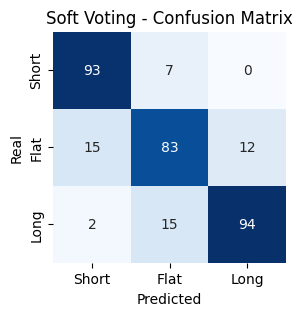

In [15]:
test_score = accuracy_score(y_test, y_pred)
train_score = accuracy_score(y_train, y_pred_train)
cm = confusion_matrix(y_test, y_pred)

print(f"VotingClassifier SoftVoting Train Score: {train_score:.4f}")
print(f"VotingClassifier SoftVoting Test Score: {test_score:.4f}")
print("Confusion Matrix:\n", cm)
plot_confusion_matrix_from_cm(cm, labels=["Short", "Flat", "Long"], title="Soft Voting - Confusion Matrix")

# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier: 1.0/0.798, nur Fehler: 0.894
# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier + SVC: 1.0/0.838, nur Fehler: 0.907
# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier (PCA) + SVC: 1.0/0.838 , nur Fehler: 0.907
# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier + SVC (PCA): 1.0/0.838 , nur Fehler: 0.907
# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier + SVC + RandomForestClassifier (PCA): 1.0/0.8385 , nur Fehler: 0.907
# Train/Test Score Soft Voting MLPClassifier + KNeighborsClassifier + SVC + RandomForestClassifier (PCA) + DecisionTree: 1.0/0.829, nur Fehler: 0.9003

In [16]:
# Methode, die nur Fehler, die fürs Trading relevant sind, bestraft
def penalize_only_errors(cm): 
    penalized_errors = [
        (0, 2),  # Short als Long vorausgesagt
        (1, 0),  # Flat als Short sgesagt
        (1, 2),  # Flat als Long vorausgesagt
        (2, 0),  # Long als Short vorausgesagt
    ]
    
    penalty_count = sum(cm[row, col] for row, col in penalized_errors)
    total = np.sum(cm)
    custom_score = 1 - penalty_count / total
    return custom_score

print(f"VotingClassifier SoftVoting Test Score (nur Fehler bestrafen): {penalize_only_errors(cm)}")

VotingClassifier SoftVoting Test Score (nur Fehler bestrafen): 0.9096573208722741


# Stacking

In [17]:
stacking_clf = StackingClassifier(
    estimators=[("MLPClassifier", model_mlpclassifier_scaleddata), ("KNeighborsClassifier", model_kneighbors_scaleddata), ("SVC", model_svc_scaleddata)],  # , ("RandomForestClassifier", model_randomforest_pcadata), ("DecisionTreeClassifier", model_desisiontree_scaleddata)
    final_estimator=model_logisticregression_scaleddata,  # default
    cv=CV,
    n_jobs=N_JOBS
)
stacking_clf.fit(X_scaled_train, y_train)

# Test-Score berechnen, predict
y_pred = stacking_clf.predict(X_scaled_test)
y_pred_train = stacking_clf.predict(X_scaled_train)

StackingClassifier Train Score: 0.9992
StackingClassifier Test Score: 0.8380
Confusion Matrix:
 [[95  5  0]
 [15 80 15]
 [ 0 17 94]]


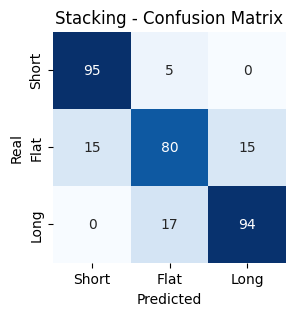

In [18]:
test_score = accuracy_score(y_test, y_pred)
train_score = accuracy_score(y_train, y_pred_train)
cm = confusion_matrix(y_test, y_pred)

print(f"StackingClassifier Train Score: {train_score:.4f}")
print(f"StackingClassifier Test Score: {test_score:.4f}")
print("Confusion Matrix:\n", cm)
plot_confusion_matrix_from_cm(cm, labels=["Short", "Flat", "Long"], title="Stacking - Confusion Matrix")

# final_estimator=model_logisticregression_scaleddata
# Train/Test Score Stacking MLPClassifier + KNeighborsClassifier: 1.0/0.8193, nur Fehler: 0.888
# Train/Test Score Stacking MLPClassifier + KNeighborsClassifier + SVC: 0.999/0.838, nur Fehler: 0.907
# Train/Test Score Stacking MLPClassifier + KNeighborsClassifier + SVC + RandomForestClassifier (PCA): 1.0/0.8318, nur Fehler: 0.897
# Train/Test Score Stacking MLPClassifier + KNeighborsClassifier + SVC + RandomForestClassifier (PCA) + DecisionTree: 1.0/0.841, nur Fehler: 0.903

In [19]:
print(f"StackingClassifier Test Score (nur Fehler bestrafen): {penalize_only_errors(cm)}")

StackingClassifier Test Score (nur Fehler bestrafen): 0.9065420560747663
